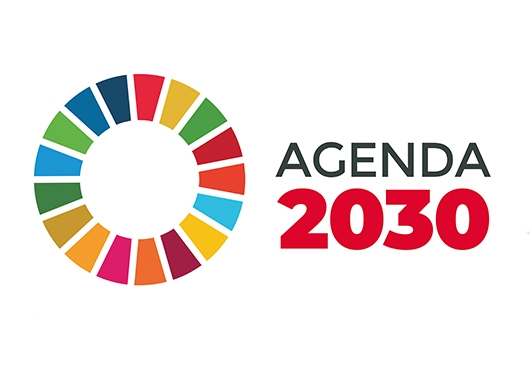

# Agenda 2030

Course: Business Intelligence  
Universidad de los Andes  
October, 2023

- Wyo Hann Chu Mendez - 202015066
- Diana Silva Alvarez - 201815366
- Sofia Velasquez Marin - 202113334


La Agenda 2030 para el Desarrollo Sostenible, aprobada en septiembre de 2015 por la Asamblea General de las Naciones Unidas, establece una visión transformadora hacia la sostenibilidad económica, social y ambiental de los 193 Estados miembros de las Naciones Unidas que la suscribieron y es la guía de referencia para el trabajo de la comunidad internacional hasta el año 2030. La Agenda 2030 presenta una oportunidad histórica para América Latina y el Caribe, ya que incluye temas altamente prioritarios para la región, como la erradicación de la pobreza extrema, la reducción de la desigualdad en todas sus dimensiones, un crecimiento económico inclusivo con trabajo decente para todos, ciudades sostenibles y cambio climático, entre otros.

Es una agenda civilizatoria, que pone la dignidad y la igualdad de las personas en el centro y llama a cambiar nuestro estilo de desarrollo. Es un compromiso universal adquirido tanto por países desarrollados como en desarrollo, en el marco de una alianza mundial reforzada, que toma en cuenta los medios de implementación para realizar el cambio y la prevención de desastres por eventos naturales extremos, así como la mitigación y adaptación al cambio climático

Dentro de la Agenda 2030, se tratan 17 objetivos de desarrollo sostenible, de los cuales en este trabajo se tendran en cuenta los numerales 3,4 y 5.



*   Objetivo 3: Garantizar una vida sana y promover el bienestar para todos en todas las edades
*   Objetivo 4: Garantizar una educación inclusiva, equitativa y de calidad y promover oportunidades de aprendizaje durante toda la vida para todos

*   Objetivo 5: Lograr la igualdad entre los géneros y empoderar a todas las mujeres y las niñas


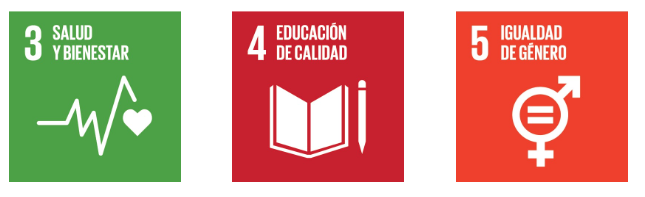

El objetivo de este documento es desarrollar un modelo de clasificación, con técnicas de aprendizaje automático, que permita relacionar de manera automática un texto según los ODS 3, 4 y 5.
Para esto se van a desarrollar 3 Learning Language Models, TD-IFD, Bag of Words y Word2Vec, los cuales seran explicados y desarrollados mas adelante en este documento.

El trabajo que hara el modelo es recibir una serie de textos que hablan de solucoines, problemas y entornos acerca de cada uno de las ODS que estamos trabajando, las cuales una vez recibidas el modelo las clasificará segun el tema que traten.

Para comenzar prepararemos los datos e importaremos las librerias necesarias para trabajar

In [4]:
# !pip install unidecode
# !pip install ftfy
import ftfy
import unicodedata
import numpy as np
import pandas as pd
from unidecode import unidecode

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import re
from sklearn.base import BaseEstimator, TransformerMixin
from joblib import dump, load




In [5]:
import warnings
warnings.filterwarnings("ignore")

In [6]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [7]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sofia\AppData\Roaming\nltk_data...


[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sofia\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [8]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

## Data loading and preparation

En este paso, se cargan los datos para hacer las pruebas y entrenamiento de nuestro modelo, se trajo una libreria para poder leer este archivo que viene en formato Excel(Openpyxl)

In [9]:
df_agenda = pd.read_excel('data/cat_345.xlsx')

In [10]:
df_agenda.shape

(3000, 2)

El principal error dentro de los datos a la hora de evaluarlo con nuestro modelo, es el encoding o formato que trae cada texto, ya que para algunos casos no se presenan ciertas tiles que son necesarias para analizar los datos.

Por ejemplo, la escritura A¡, representa la á.

Para solucionar esto se hace uso de la funcion encode, para pasar todas estas representaciones con tildes.

Sin embargo, hay ciertos caracteres con ligeros cambios dento del documento, como por ejemplo que se tiene una A normal y no con el giño superior. Por ello tambien se prepara una funcion replace para evitar las incongruencias y errores.

In [11]:


df_agenda['Textos_espanol'] = df_agenda['Textos_espanol'].apply(ftfy.fix_text)

def remove_punctuation(text):
    # Use ftfy to fix text and remove punctuation points using regular expression
    cleaned_text = ftfy.fix_text(text)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
    return cleaned_text
df_agenda['Textos_espanol'] = df_agenda['Textos_espanol'].apply(lambda x: x.lower())

# Apply remove_punctuation function to 'Textos_espanol' column
df_agenda['Textos_espanol'] = df_agenda['Textos_espanol'].apply(remove_punctuation)









In [12]:
# #!pip install langdetect
# from langdetect import detect

# # Assuming you have the DataFrame df_agenda with a column 'Textos_espanol'

# # Function to detect the language of a paragraph
# def detect_language(text):
#     try:
#         language = detect(text)
#         return language
#     except:
#         # If language detection fails, return 'unknown'
#         return 'unknown'

# # Apply language detection to the 'Textos_espanol' column and create a new column 'Language'
# df_agenda['Language'] = df_agenda['Textos_espanol'].apply(detect_language)

# # Filter out rows where the detected language is not Spanish ('es')
# df_agenda = df_agenda[df_agenda['Language'] == 'es']



In [13]:
# print(df_agenda['Language'].value_counts())

In [14]:
df_agenda.sample(50)

,Textos_espanol,sdg
1695,las mayores proporciones de personal con cualificaciones de bajo nivel se relacionaron con resultados menos favorables de los niños en el ámbito socioemocional relaciones sociales con sus compañeros y cooperación no existe una relación simple entre el nivel de formación del personal y la calidad de las aulas o los resultados del aprendizaje estudiaron la relación entre los resultados de los niños y las cualificaciones del personal y no encontraron ninguna asociación entre ambos o la encontraron contradictoria,4
1365,los investigadores en noruega no están de acuerdo con algunas de las interpretaciones hechas por el det sobre el programa afl y algunos investigadores tampoco están de acuerdo con la estrategia de implementación utilizada por el det estas señales contradictorias son un desafío para las escuelas el programa iniciado por la dirección de educación y capacitación ha logrado hasta cierto punto establecer una infraestructura para el desarrollo del conocimiento en la profesión docente los líderes escolares y los docentes que han estado involucrados en el proyecto conocen parte de la bibliografía teórica y la investigación sobre evaluación y pueden encontrar nueva bibliografía y desarrollar teorías que puedan brindar nuevos conocimientos en su trabajo diario con los estudiantes,4
1025,de este modo todos los alumnos de cualquier asignatura pueden recuperar y acelerar su aprendizaje en los últimos años varios países de la ocde como austria la república checa francia y luxemburgo han restringido las circunstancias en las que se aplica la repetición de curso el progreso académico por sí solo puede proporcionar una información demasiado limitada sobre la mejora de los alumnos,4
2428,sin embargo existe una penalización salarial por maternidad en el caso de las trabajadoras informales el logaritmo natural previsto del salario por hora es de 115 pesos para las no madres y de 098 pesos para las madres la brecha salarial positiva de 016 a favor de las no madres es significativa y casi toda la diferencia 75 no tiene explicación o está asociada con una posible discriminación por lo tanto estos hallazgos confirman la hipótesis original de una penalización salarial por maternidad en el sector informal y la mayor parte de esta penalización es atribuible a la discriminación o a factores no observados17 también vale la pena señalar que este diferencial de 016 en el sector informal está en la parte superior fin de la distribución de las estimaciones de penalización salarial por maternidad informadas anteriormente,5
989,el reto futuro del sns es ser capaz de mantener la motivación de su plantilla y contener e invertir la fuga de profesionales sin embargo no es probable que el escaso número de enfermeros aumente en un futuro próximo mientras que el número de licenciados en medicina ha aumentado de forma constante a lo largo del tiempo el número de licenciados en enfermería ha ido disminuyendo desde 2009 en particular las mejoras sanitarias y el aumento de la actividad en el sns se obtuvieron sin recursos adicionales lo que indica tanto una mejora de la relación calidadprecio como la existencia de grandes ineficiencias en el sistema,3
2751,otro servicio de sde que debe ampliarse es el apoyo para ayudar a las mujeres a transferir sus negocios del sector informal al formal también podrían aprovechar la tecnología y los medios sociales como vehículos para prestar apoyo a las mujeres que desean gestionar mejor los horarios de trabajo y los compromisos familiares mediante la creación de una empresa a domicilio además el personal de los sde que participa directamente en la prestación de servicios de formación asesoramiento orientación u otros servicios de sde debe tener la oportunidad de adquirir experiencia y conocimientos y aprender sobre las mejores prácticas en la promoción y el apoyo a las pequeñas empresas y a las mujeres empresarias en particular,5
83,la escasez se siente principalmente de médicos y enfermeras de fami

In [15]:
df_agenda["sdg"].value_counts(dropna=False, normalize=True)

sdg
3    0.333333
4    0.333333
5    0.333333
Name: proportion, dtype: float64

In [16]:
df_agenda["Textos_espanol"] = df_agenda["Textos_espanol"].astype(str)


## Data splitting

Aca se preparan los datos para realizar los entrenamientos y pruebas de los datos a usar.

In [17]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_agenda[["Textos_espanol"]], df_agenda["sdg"], test_size=0.3, stratify=df_agenda["sdg"], random_state=1)

In [18]:
X_train.shape, X_test.shape

((2100, 1), (900, 1))

In [19]:
pd.Series(y_train).value_counts(normalize=True)

sdg
4    0.333333
3    0.333333
5    0.333333
Name: proportion, dtype: float64

In [20]:
pd.Series(y_test).value_counts(normalize=True)

sdg
3    0.333333
4    0.333333
5    0.333333
Name: proportion, dtype: float64

## Text vectorization

En este apartado tenemos la preparacion de dimensiones para nuestros tres algoritmos, TD-IDF, BOW y Word2Vec


Bag Of Words

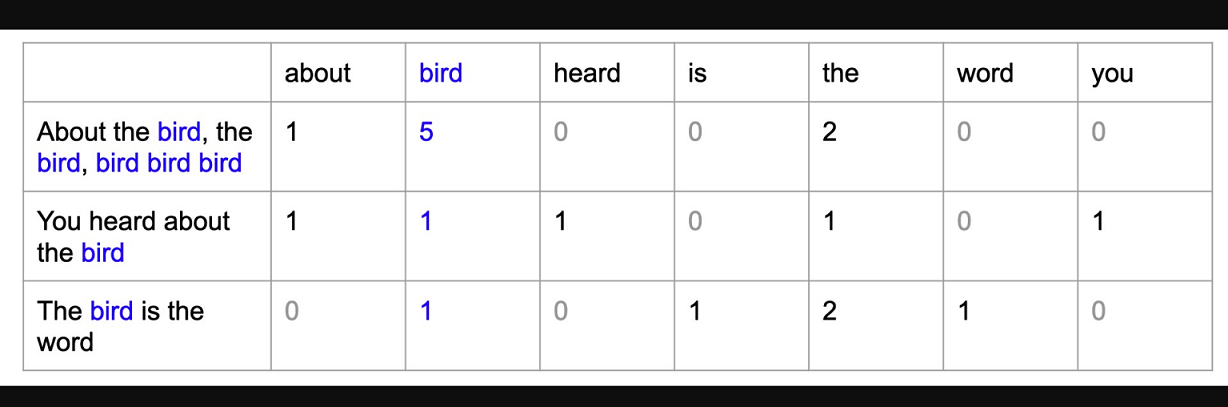

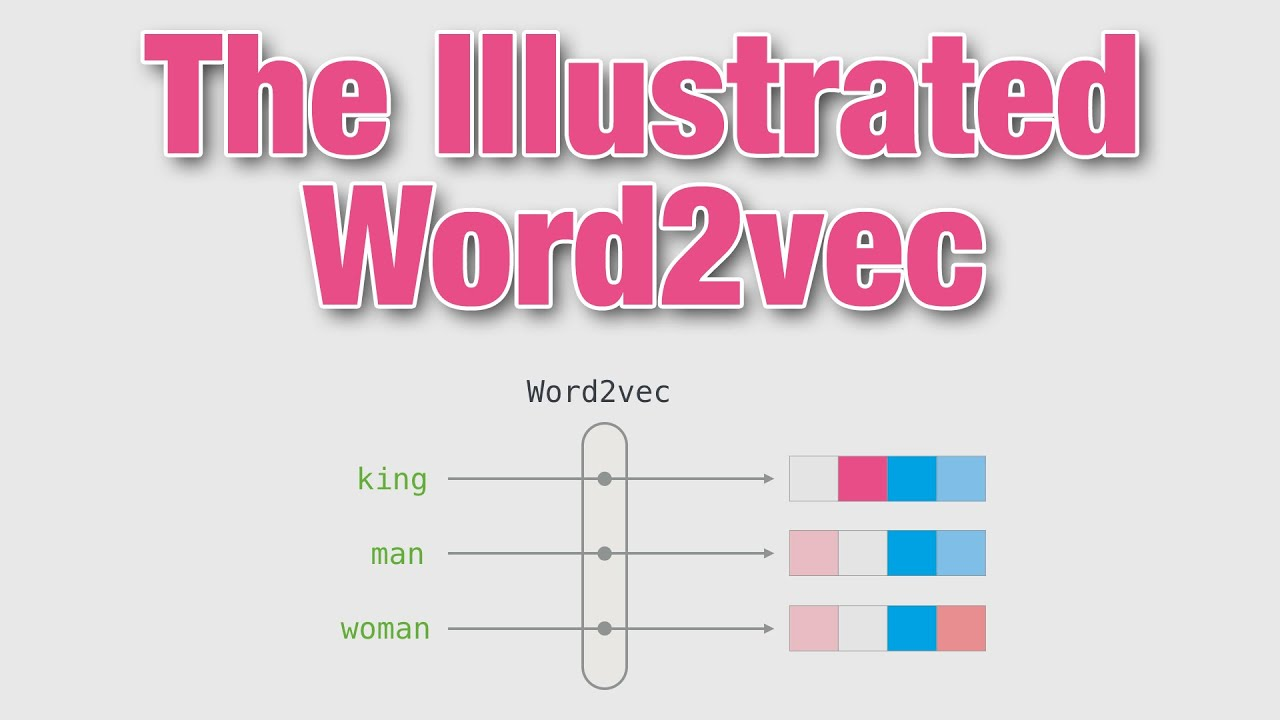

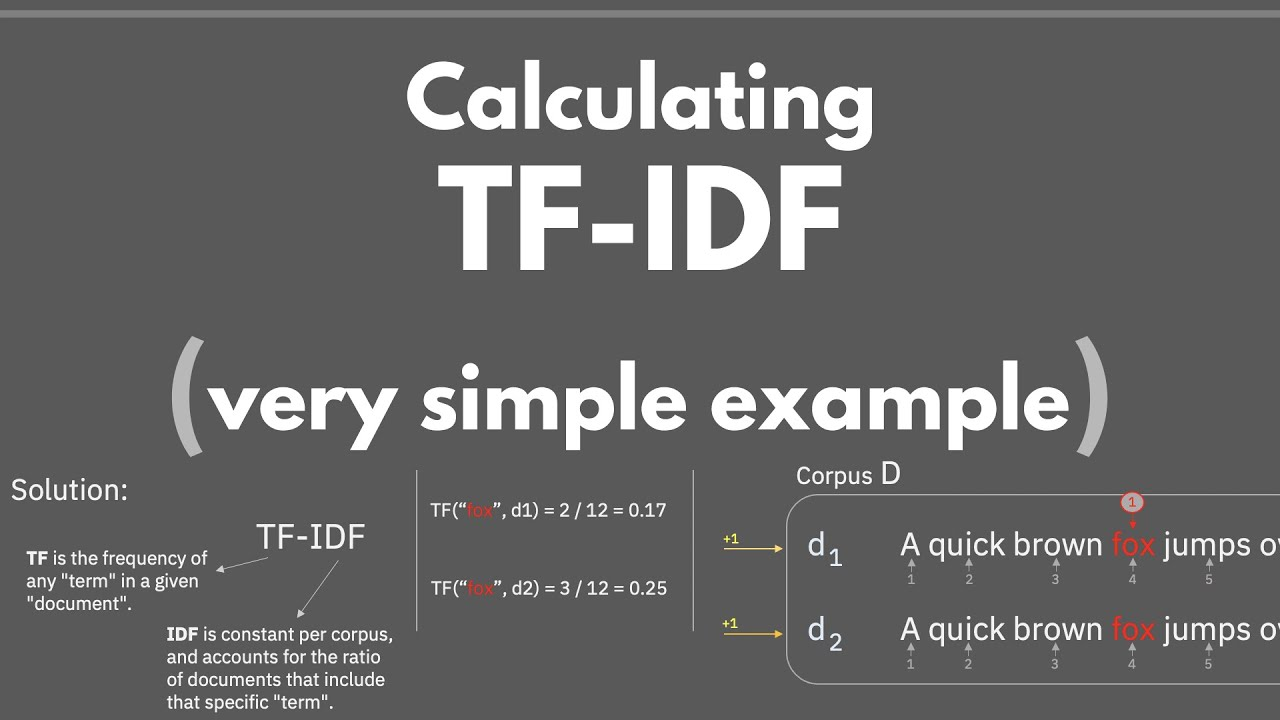

In [21]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [22]:
X_bow = bow.fit_transform(X_train["Textos_espanol"])

In [23]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 14774


In [24]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [25]:
X_tfidf = tfidf.fit_transform(X_train["Textos_espanol"])

In [26]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 14774


## Entrenamiento para el modelo Bag Of Words

El Bag of Words (BoW) es una técnica de procesamiento de texto utilizada en procesamiento de lenguaje natural (NLP) y minería de texto. La técnica consiste en representar un documento de texto como un conjunto (bag) de palabras, ignorando el orden y la estructura gramatical de las palabras en el texto.
En el modelo BoW, se crea un vocabulario de todas las palabras únicas en un conjunto de documentos de texto, y cada documento se representa como un vector de tamaño igual al tamaño del vocabulario. Cada posición en el vector representa una palabra en el vocabulario, y el valor en la posición indica la frecuencia de la palabra en el documento.
Por ejemplo, si el vocabulario contiene las palabras “gato”, “perro” y “juguete”, y un documento tiene una frecuencia de dos para la palabra “gato”, una frecuencia de tres para la palabra “perro” y una frecuencia de cero para la palabra “juguete”, entonces el vector de representación BoW para este documento sería [2,3,0]

Basicamente como se represento en la imagen de la parte superior, se crea una matriz por cada palabra que se contiene en el texto y se hace un conteo por cada una de ellas.

Para esto vamos a desarrollar los algoritmos y se realizaran Matrices de confusión para ver las eficiencias y que sean mas claros los calculos y los diferentes scores.

In [27]:
bow_model = RandomForestClassifier(random_state=42)

In [28]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=42)

<Axes: >

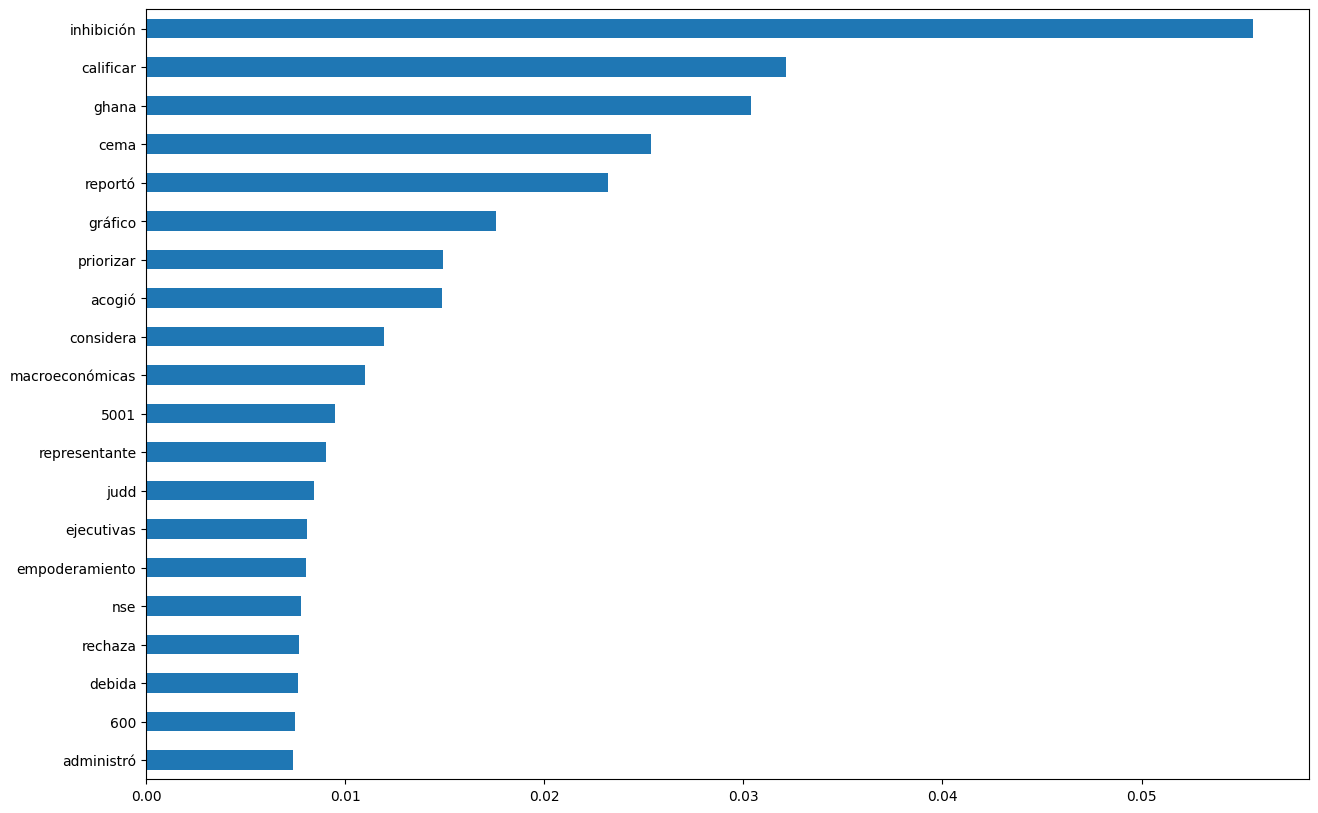

In [29]:
# Feature importance in tree models is an indicator on how relevant is a feature for taking the decision by the model
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [30]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 100.64


In [31]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Textos_espanol"]))

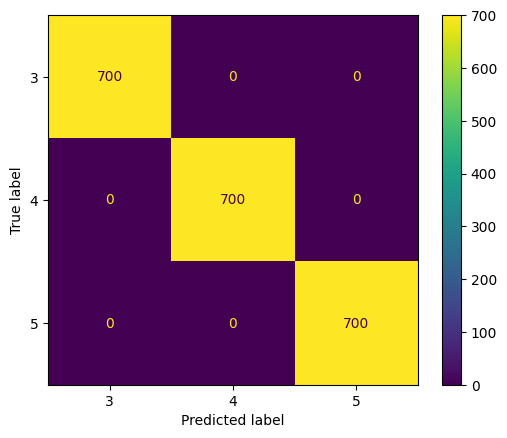

In [32]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

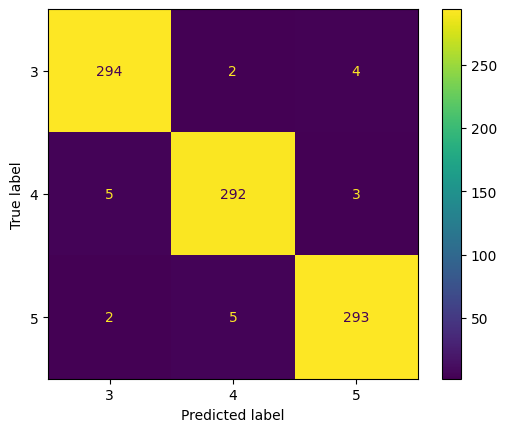

In [33]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [34]:
print("Precision:", precision_score(y_train, y_train_bow_predict, average='micro'))
print("Recall:", recall_score(y_train, y_train_bow_predict,average='micro'))
print("F1:", f1_score(y_train, y_train_bow_predict,average='micro'))
print("Accuracy:", accuracy_score(y_train, y_train_bow_predict))


Precision: 1.0
Recall: 1.0
F1: 1.0
Accuracy: 1.0


In [35]:
print("Precision:", precision_score(y_test, y_test_bow_predict, average='micro'))
print("Recall:", recall_score(y_test, y_test_bow_predict, average='micro'))
print("F1:", f1_score(y_test, y_test_bow_predict, average='micro'))
print("Accuracy:", accuracy_score(y_test, y_test_bow_predict))

Precision: 0.9766666666666667
Recall: 0.9766666666666667
F1: 0.9766666666666667
Accuracy: 0.9766666666666667


## Entrenameinto para el modelo TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) es una medida utilizada en el procesamiento del lenguaje natural (NLP) para evaluar la importancia de una palabra en un documento dentro de una colección de documentos.

La frecuencia de término (TF) se refiere a la frecuencia con la que una palabra aparece en un documento. La frecuencia de documento inversa (IDF) se refiere a la frecuencia con la que una palabra aparece en la colección de documentos. Una palabra con un alto TF-IDF es aquella que aparece con frecuencia en el documento, pero no aparece con frecuencia en la colección de documentos. Esto sugiere que la palabra es importante para el documento en particular y puede ser útil para distinguirlo de otros documentos.

En este caso comom venimos trabajando, la idea es que este modelo tomem parte de los datos para proximamente indentifiar las clases de los ODS.

In [36]:
tfidf_model = RandomForestClassifier(random_state=3)

In [37]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

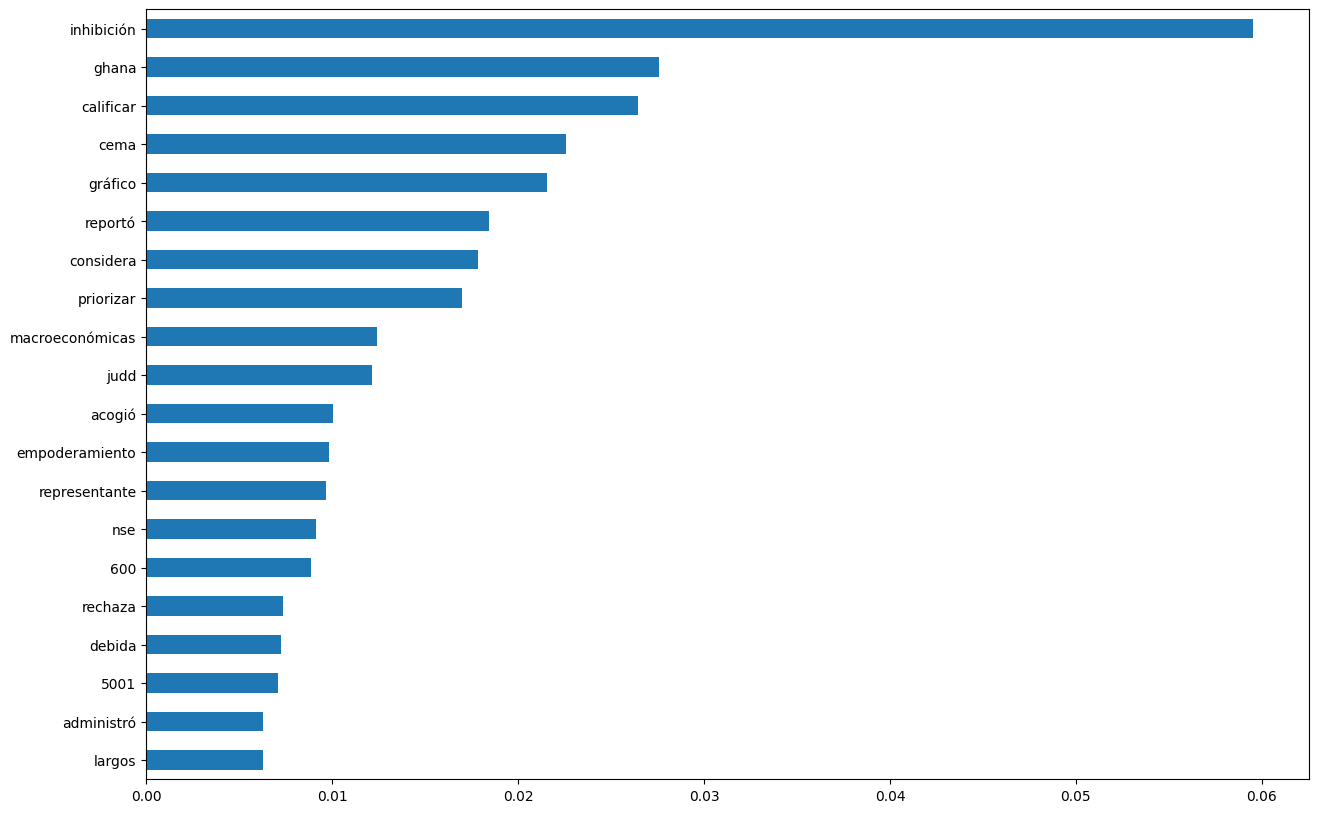

In [38]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [39]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 100.26


In [40]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Textos_espanol"]))

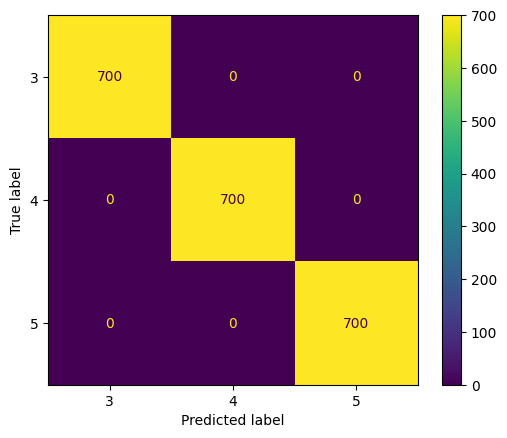

In [41]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

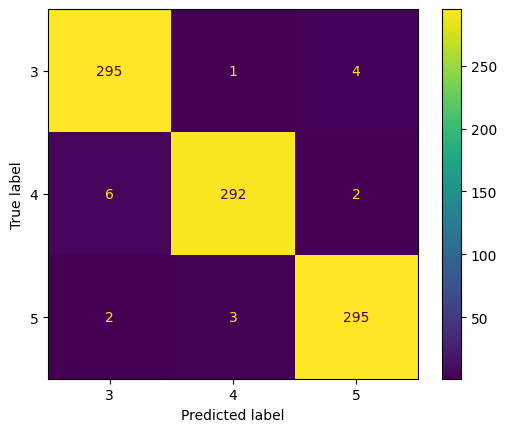

In [42]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [43]:
print("Precision:", precision_score(y_train, y_train_tfidf_predict, average='micro'))
print("Recall:", recall_score(y_train, y_train_tfidf_predict, average='micro'))
print("F1:", f1_score(y_train, y_train_tfidf_predict, average='micro'))
print("Accuracy:", accuracy_score(y_train, y_train_tfidf_predict))

Precision: 1.0
Recall: 1.0
F1: 1.0
Accuracy: 1.0


In [44]:
print("Precision:", precision_score(y_test, y_test_tfidf_predict, average='micro'))
print("Recall:", recall_score(y_test, y_test_tfidf_predict, average='micro'))
print("F1:", f1_score(y_test, y_test_tfidf_predict, average='micro'))
print("Accuracy:", accuracy_score(y_test, y_test_tfidf_predict))

Precision: 0.98
Recall: 0.98
F1: 0.98
Accuracy: 0.98


## Entrenamiento para el modelo Word2Vec


Word2Vec es un algoritmo de aprendizaje automático que se utiliza para crear representaciones vectoriales de palabras. Estas representaciones vectoriales capturan las relaciones semánticas y sintácticas entre las palabras, y se pueden utilizar para una amplia gama de tareas de procesamiento del lenguaje natural (NLP), como la búsqueda semántica, la recomendación de productos y el análisis de sentimientos.

Word2Vec funciona entrenando un modelo de lenguaje neuronal en un gran corpus de texto. El modelo aprende a predecir la probabilidad de que una palabra aparezca en un contexto dado. Por ejemplo, el modelo podría aprender a predecir que la palabra "perro" es más probable que aparezca en el contexto de las palabras "animal" y "mascota" que en el contexto de las palabras " coche " y "ordenador"

Este sera nuestro ultimo modelo a probar con la informacion sobre los ODS. **Tengase en cuenta que los dos algoritmos anteriores son mucho mejores y tienen mayor trabajo y eficiencia esperada para estos Learning Language Model**

Por ello mismo debido al manejo del tokenizer especializado del modelo, se crea la columna para que el algoritmo pueda trabajar con los datos tippeados de la forma en la que lo necesita.

In [45]:
df_agenda['tokenized_text'] = df_agenda['Textos_espanol'].apply(lambda x: word_tokenize(x.lower()))

In [46]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(df_agenda['tokenized_text'], df_agenda['sdg'], test_size=0.3, random_state=42)

In [47]:
# Train Word2Vec model
word2vec_model = Word2Vec(sentences=X_train_, vector_size=100, window=5, min_count=1, workers=4)


In [48]:
# Function to generate average word vectors for a sentence
def average_word_vectors(words, model, num_features):
    feature_vector = np.zeros((num_features,), dtype="float32")
    num_words = 0

    for word in words:
        if word in model.wv:
            num_words += 1
            feature_vector = np.add(feature_vector, model.wv[word])

    if num_words > 0:
        feature_vector = np.divide(feature_vector, num_words)

    return feature_vector

# Create feature vectors for the test data
num_features = 100  # Adjust the dimensionality of your word vectors
X_test_word2vec = [average_word_vectors(words, word2vec_model, num_features) for words in X_test_]


In [49]:
num_features = 100  # Adjust the dimensionality of your word vectors
X_train_word2vec = [average_word_vectors(words, word2vec_model, num_features) for words in X_train_]
X_test_word2vec = [average_word_vectors(words, word2vec_model, num_features) for words in X_test_]
# Initialize and train a classifier (for example, Logistic Regression)
classifier = LogisticRegression()
classifier1 = LogisticRegression()

classifier.fit(X_train_word2vec, y_train_)
classifier1.fit(X_test_word2vec, y_test_)


# Make predictions
predictions = classifier.predict(X_test_word2vec)
predictions1 = classifier1.predict(X_train_word2vec)



# Evaluate the classifier
accuracytrain = accuracy_score(y_test_, predictions)
accuracytest = accuracy_score(y_train_, predictions1)




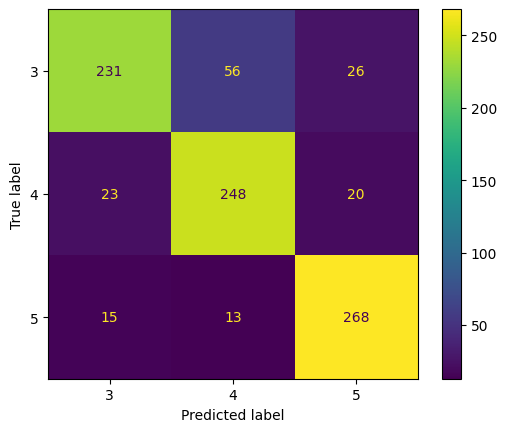

In [50]:
ConfusionMatrixDisplay.from_predictions(y_test_, predictions)

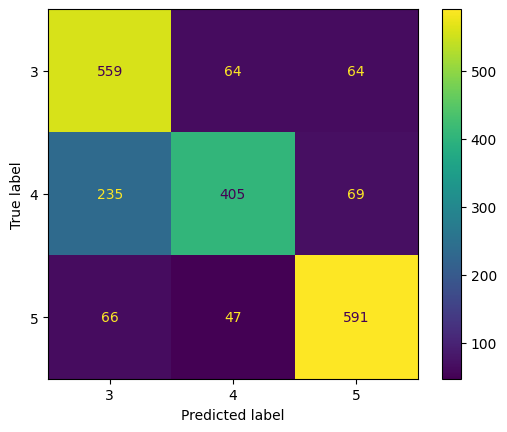

In [51]:
ConfusionMatrixDisplay.from_predictions(y_train_, predictions1)

In [52]:
accuracytrain

0.83

In [53]:
accuracytest

0.7404761904761905

In [54]:
print("Precision:", precision_score(y_train_, predictions1, average='micro'))
print("Recall:", recall_score(y_train_, predictions1, average='micro'))
print("F1:", f1_score(y_train_, predictions1, average='micro'))
print("Accuracy:", accuracy_score(y_train_, predictions1))

Precision: 0.7404761904761905
Recall: 0.7404761904761905
F1: 0.7404761904761906
Accuracy: 0.7404761904761905


In [55]:
print("Precision:", precision_score(y_test_, predictions, average='micro'))
print("Recall:", recall_score(y_test_, predictions, average='micro'))
print("F1:", f1_score(y_test_, predictions, average='micro'))
print("Accuracy:", accuracy_score(y_test_, predictions))

Precision: 0.83
Recall: 0.83
F1: 0.83
Accuracy: 0.83


## Seleccion del modelo (pipeline) Modelo TF-IDF RandomizedSearchCV

---



Primero haremos una clase que haga el preprocesamiento de los datos

In [56]:
class Preprocessing  (BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self

  def remove_punctuation(self, text):
      # Use ftfy to fix text and remove punctuation points using regular expression
      cleaned_text = ftfy.fix_text(text)
      cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)
      return cleaned_text

  def transform (self, X):
      X['Textos_espanol'] = X['Textos_espanol'].apply(ftfy.fix_text)
      X['Textos_espanol'] = X['Textos_espanol'].apply(lambda x: x.lower())
      # Apply remove_punctuation function to 'Textos_espanol' column
      X['Textos_espanol'] = X['Textos_espanol'].apply(self.remove_punctuation)
      X["Textos_espanol"] = X["Textos_espanol"].astype(str)

      return X["Textos_espanol"]

In [57]:
pipeline = Pipeline(steps = [
    ("preprocessing", Preprocessing()),
    ("vectorizer", CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", RandomForestClassifier(random_state=49))
])

In [58]:
param_grid = {
    "vectorizer": [CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words), TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words)],
    "vectorizer__lowercase": [True, False],
    "classifier__n_estimators": [50, 100],
    "classifier__criterion": ['gini', 'entropy'],
    "classifier__max_depth": [25, 50, 75, 100]
}

In [59]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=15, scoring=["precision", "recall", "f1"], refit="f1", cv=3, return_train_score=True, verbose=1, random_state=43)

In [60]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits


RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('preprocessing', Preprocessing()),
                                             ('vectorizer',
                                              CountVectorizer(stop_words=['de',
                                                                          'la',
                                                                          'que',
                                                                          'el',
                                                                          'en',
                                                                          'y',
                                                                          'a',
                                                                          'los',
                                                                          'del',
                                                                          'se',
                                                                          'las',
                                                                          'por',
                                                                          'un',
                                                                          'para',
                                                                          'con',
                                                                          'no',
                                                                          'una',
                                                                          'su',
                                                                          'al',
                                                                          'lo',
                                                                          'como',
                                                                          'más',
                                                                          'pero',
                                                                          'sus',
                                                                          'le',
                                                                          'ya',
                                                                          'o',
                                                                          'este',
                                                                          'sí',
                                                                          'porque', ...],
                                                              tokenizer=<function word_tokenize at 0x0000023F4D9B18A...
                                                                                   'que',
                                                                                   'el',
                                                                                   'en',
                                                                                   'y',
                                                                                   'a',
                                                                                   'los',
                                                                                   'del',
                                                                                   'se',
                                                                                   'las',
                                                                                   'por',
                                                                                   'un',
                                                                                   'para',
                                                                                   'con',
                                                                                   'no',
                                      

In [61]:
search.best_params_

{'vectorizer__lowercase': False,
 'vectorizer': TfidfVectorizer(lowercase=False,
                 stop_words=['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los',
                             'del', 'se', 'las', 'por', 'un', 'para', 'con',
                             'no', 'una', 'su', 'al', 'lo', 'como', 'más',
                             'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí',
                             'porque', ...],
                 tokenizer=<function word_tokenize at 0x0000023F4D9B18A0>),
 'classifier__n_estimators': 100,
 'classifier__max_depth': 50,
 'classifier__criterion': 'entropy'}

In [62]:
search.best_estimator_

Pipeline(steps=[('preprocessing', Preprocessing()),
                ('vectorizer',
                 TfidfVectorizer(lowercase=False,
                                 stop_words=['de', 'la', 'que', 'el', 'en', 'y',
                                             'a', 'los', 'del', 'se', 'las',
                                             'por', 'un', 'para', 'con', 'no',
                                             'una', 'su', 'al', 'lo', 'como',
                                             'más', 'pero', 'sus', 'le', 'ya',
                                             'o', 'este', 'sí', 'porque', ...],
                                 tokenizer=<function word_tokenize at 0x0000023F4D9B18A0>)),
                ('classifier',
                 RandomForestClassifier(criterion='entropy', max_depth=50,
                                        random_state=49))])

In [63]:
y_train_search_predict = search.best_estimator_.predict(X_train)
y_test_search_predict = search.best_estimator_.predict(X_test)

In [64]:
print("Precision:", precision_score(y_train, y_train_search_predict, average='micro'))
print("Recall:", recall_score(y_train, y_train_search_predict, average='micro'))
print("F1:", f1_score(y_train, y_train_search_predict, average='micro'))
print("Accuracy:", accuracy_score(y_train, y_train_search_predict))

Precision: 0.9990476190476191
Recall: 0.9990476190476191
F1: 0.9990476190476191
Accuracy: 0.9990476190476191


In [65]:
print("Precision:", precision_score(y_test, y_test_search_predict, average='micro'))
print("Recall:", recall_score(y_test, y_test_search_predict, average='micro'))
print("F1:", f1_score(y_test, y_test_search_predict, average='micro'))
print("Accuracy:", accuracy_score(y_test, y_test_search_predict))

Precision: 0.9811111111111112
Recall: 0.9811111111111112
F1: 0.9811111111111112
Accuracy: 0.9811111111111112


In [66]:
filename = 'model.joblib'

In [67]:
dump(search.best_estimator_, filename)

['model.joblib']

## Predicción sobre los datos unlabeled


In [68]:
pipeline_loaded = load(filename)

In [70]:
df_unlabeled = pd.read_excel('data/SinEtiquetatest_cat_345.xlsx')

In [ ]:
predict = pipeline_loaded.predict(df_unlabeled)

In [ ]:
df_unlabeled["sdg"] = predict

In [ ]:
df_unlabeled.to_csv("data/resultado_prediccion(csv).csv", index=False)

In [ ]:
df_unlabeled.to_excel("data/resultado_prediccion(xlsx).xlsx", index=False)